In [8]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import scipy.linalg as la
import csv

In [54]:
# Lattice vectors
a1 = np.array([1.0,0.0],dtype = complex)  
a2 = np.array([0.0,1.0],dtype = complex)   

b1 = np.array([1.0,0.0],dtype = complex)
b2 = np.array([0.0,1.0],dtype = complex)

# special points in the MBZ
gpt = 2*np.pi*np.array([0.0,0.0], dtype = complex) # The Gamma point
xpt = 2*np.pi*np.array([0.5,0.0], dtype = complex) # The X point
ypt = 2*np.pi*np.array([0.0,0.5], dtype = complex) # The Y point
mpt = 2*np.pi*np.array([0.5,0.5], dtype = complex) # The M point

In [3]:
ax1, ay1 = a1
ax2, ay2 = a2
omega = abs(ax1 * ay2 - ay1 * ax2) # area of the unit cell
    
z1 = (ax1 + 1.0j*ay1)/np.sqrt(omega) # z
z1bar = (ax1 - 1.0j*ay1)/np.sqrt(omega)
z2 = (ax2 + 1.0j*ay2)/np.sqrt(omega)
z2bar = (ax2 - 1.0j*ay2)/np.sqrt(omega)

Here we load the form factors calculated from the mathematica script.  There are serious issues with precision and the evaluation of the Laguerre polynomials at higher values of $m, n$, so we opt to do it in Mathematica and load the results for ${\cal H}^{2\pi b_1}$ in formFactors1, and ${\cal H}^{2\pi b_2}$ in formFactors2.

In [29]:
formFactors1 = np.zeros((100,100),dtype=complex)
formFactors2 = np.zeros((100,100),dtype=complex)

file1 = open('./TBG_1.csv', 'r')
for j,line in enumerate(file1.readlines()):
    formFactors1[j] = [complex(i.replace('*^','e').replace('*I','j')) for i in line.split(',')]
    
file2 = open('./TBG_2.csv', 'r')
for j,line in enumerate(file2.readlines()):
    formFactors2[j] = [complex(i.replace('*^','e').replace('*I','j')) for i in line.split(',')]

In [51]:
def distance(a,b): # finds the distance between two vectors
    x0, y0 = np.real(a) # because they were complex, cast to real and then unpack to get x, y
    x1, y1 = np.real(b)
    return(np.sqrt((x0-x1)**2 + (y0 - y1)**2))

Now we diagonalize the Hamiltonian, using Eq.(B10)
weak potential, $w = 1.0$:

$$H^{\phi=2\pi}_{mn}(\mathbf{k}) = \phi(m+\frac{1}{2}) \delta_{mn} + \frac{w}{2} (e^{- i k_2}  \mathcal{H}^{2\pi \mathbf{b}_1}_{mn} + e^{i k_1} \mathcal{H}^{2\pi \mathbf{b}_2}_{mn} + H.c.)$$

In [53]:
w = 1.0
phi = 2*np.pi

In [57]:
num_landau = 20 # number of Landau levels to keep
kinetic = np.zeros((num_landau,num_landau)) # matrix to hold the kinetic energies corresponding to each LL

# First create the kinetic terms
for m in range(num_landau): 
    kinetic[m][m] = phi*(m+1./2)

def generateHam(k): # given a momentum k,
    k1 = np.dot(a1,k)
    k2 = np.dot(a2,k)
    hamiltonian = kinetic + w/2*formFactors1[:num_landau,:num_landau]*np.exp( 1.0j *(-k2)) \
    + w/2*formFactors2[:num_landau,:num_landau]*np.exp(1.0j *(k1)) \
    + w/2*(formFactors1.conj().T)[:num_landau,:num_landau]*np.exp(1.0j *(k2)) \
    + w/2*(formFactors2.conj().T)[:num_landau,:num_landau]*np.exp(1.0j *(-k1))     
    return(hamiltonian)

We create a band structure plot linking the different high-symmetry points in the BZ: $Y \rightarrow -X \rightarrow \Gamma \rightarrow X \rightarrow M \rightarrow \Gamma$.

In [58]:
# generate path in MBZ to plot
numpoints = 50 # path divided into pieces.
y_to_mx = [ypt * (1.0 - (t+0.0)/numpoints) + (-xpt) * ((t+0.0)/numpoints) for t in range(numpoints)] # from Y to -X
mx_to_g = [(-xpt) * (1.0 - (t+0.0)/numpoints) + gpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from -X to Gamma
g_to_x = [gpt * (1.0 - (t+0.0)/numpoints) + xpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from Gamma to X
x_to_m = [xpt * (1.0 - (t+0.0)/numpoints) + mpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from X to M
m_to_g = [mpt * (1.0 - (t+0.0)/numpoints) + gpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from M to Gamma

list_of_points = y_to_mx+mx_to_g+g_to_x+x_to_m+m_to_g # + means append here, so the list is 5*numpoints long
array_of_points = np.array(list_of_points) # to numpy array

# some intervals between points are longer than others.  Fix by normalizing by length
len_k = [0.0] # this is the x-axis of the band structure plot.  starting at 0,
prev_k = 0.0
for i in range(len(list_of_points) - 1):
    prev_k += distance(array_of_points[i+1],array_of_points[i]) # add distances cumulatively
    len_k.append(prev_k)

In [59]:
listOfEigenvals = []  # will hold all the eigenvalues.
for i, k_vec in enumerate(list_of_points):  # for each k-point in the path
    ham = generateHam(k_vec)  # build Hk
    eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
    listOfEigenvals.append(eigenvals)  # add to list

Here we gather a whole bunch of points to histogram together.  This would be infeasible in the open space momentum technique

In [66]:
listOfValsForHistogram = []

for i in range(50): # 2500 points to create histogram
    for j in range(50):
        ham = generateHam(2*np.pi*i/50.0*b1+2*np.pi*j/50.0*b2)
        eigval, eigvec = np.linalg.eigh(ham)
        listOfValsForHistogram.append(eigval[:5]) # for the first 5 bands

Some quantities that will help normalize the histogram

In [67]:
hist = np.array(listOfValsForHistogram).flatten()
a, b = np.histogram(hist, bins=200)
q = b[:200] + np.diff(b)/2.0
b[0]-np.diff(b)[0]/2.0
b[-1]+np.diff(b)[0]/2.0
np.diff(b)[3]*sum(a)

1636.2530828567312

Text(0.3, 10, 'D.O.S.')

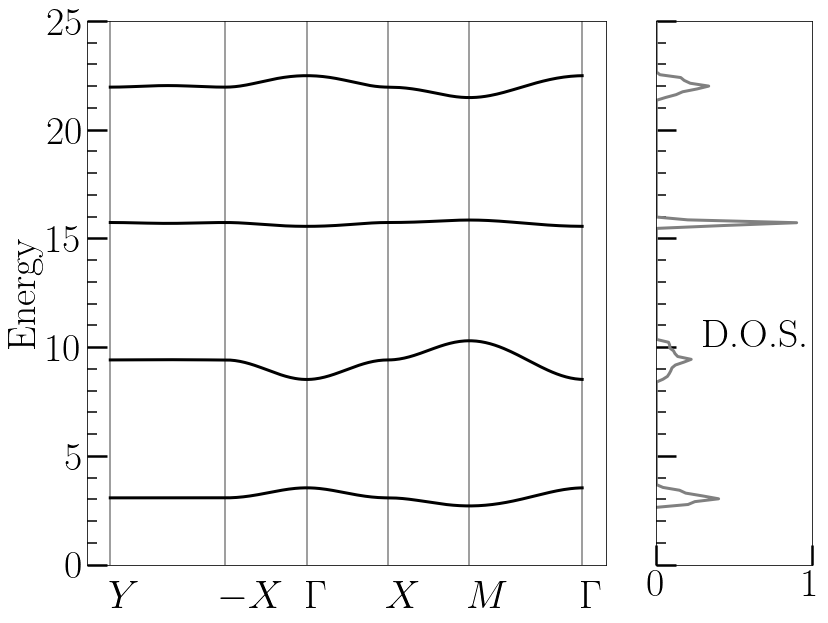

In [68]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 10), gridspec_kw={'width_ratios': [1,0.3]})
plt.subplots_adjust(wspace=0.15)

axes[0].get_xaxis().set_visible(False)
axes[0].tick_params(direction="in",width=2.5, length=20)

axes[0].axes.get_xaxis().set_visible(False)

arrayOfEigenvals=np.array(listOfEigenvals)# take the 8 bands closest to 0 energy
axes[0].axvline(x=len_k[0], color='gray')
axes[0].text(len_k[0]-.05,-2,r'$Y$',rotation=0)
axes[0].axvline(x=len_k[50], color='gray')
axes[0].text(len_k[50]-.2,-2,r'$-X$',rotation=0)
axes[0].axvline(x=len_k[100], color='gray')
axes[0].text(len_k[100]-.025,-2,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[150], color='gray')
axes[0].text(len_k[150]-.125,-2,r'$X$',rotation=0)
axes[0].axvline(x=len_k[200], color='gray')
axes[0].text(len_k[200]-.1,-2,r'$M$',rotation=0)
axes[0].axvline(x=len_k[249], color='gray')
axes[0].text(len_k[249]-.05,-2,r"$\Gamma$",rotation=0)
axes[0].set_ylim([0, 25])
axes[0].set_ylabel('Energy')

for i in range(0,4):
    axes[0].plot(len_k, arrayOfEigenvals[:,i],linewidth=3,color='black')

axes[0].get_yaxis().set_major_locator(MultipleLocator(5))
axes[0].get_yaxis().set_minor_locator(MultipleLocator(1))
axes[0].tick_params(which='major',direction="in",width=2.5, length=20)
axes[0].tick_params(which='minor',direction="in",width=1.5, length=10)
    
axes[1].get_yaxis().set_ticklabels([])
axes[1].get_yaxis().set_major_locator(MultipleLocator(50))
axes[1].get_yaxis().set_minor_locator(MultipleLocator(10))

ap = np.concatenate(([0],a,[0]))
qp = np.concatenate(([b[0]-np.diff(b)[0]/2.0],q,[b[-1]+np.diff(b)[0]/2.0]))

axes[1].plot(ap/1636, qp, linewidth=3, color='gray')
axes[1].get_yaxis().set_major_locator(MultipleLocator(5))
axes[1].get_yaxis().set_minor_locator(MultipleLocator(1))
axes[1].tick_params(which='major',direction="in",width=2.5, length=20)
axes[1].tick_params(which='minor',direction="in",width=1.5, length=10)

axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 25])

axes[0].tick_params(direction="in",width=2.5, length=20)
axes[1].text(0.3,10,r"D.O.S.",rotation=0)
plt.savefig('SquareFluxLowW.png',bbox_inches='tight')

Now we calculate the Wilson loop.  Start by defining the paths to calculate the Wilson loop over, and then creating the $\tilde{Z}$ matrices as defined in Eq.(A143)

In [70]:
path_k1 = [[2*np.pi*b1*(j)/150.0+2*np.pi*b2*i/150.0 for i in range(150)] for j in range(150)] # path to integrate Wilson loop

$$\tilde{Z}_i = \frac{1}{\sqrt{4\pi}} \langle m | \bar{z}_i a + z_i a^\dagger | n \rangle $$
$$= \frac{1}{\sqrt{4\pi}} [\bar{z}_i \sqrt{n} \delta_{m,n-1} + z_i \sqrt{n+1}\delta_{m,n+1}] $$
$$= \frac{1}{\sqrt{4\pi}} [\bar{z}_i \sqrt{n} \delta_{m,n-1} + z_i \sqrt{m}\delta_{m,n+1}] $$

In [73]:
# create the Z_matrix.  We're only keeping 20 Landau levels
num_landau = 20
z1_total_mat = np.zeros((num_landau,num_landau),dtype = complex)
z2_total_mat = np.zeros((num_landau,num_landau),dtype = complex)

for m in range(num_landau):
    for n in range(num_landau):
        if (m-1 == n):
            coeff = 1.0/np.sqrt(4*np.pi)
            z1_total_mat[m][n] += z1*np.sqrt(m)*coeff
            z2_total_mat[m][n] += z2*np.sqrt(m)*coeff
            
        elif (m == n-1):
            coeff = 1.0/np.sqrt(4*np.pi)
            z1_total_mat[m][n] += z1bar*np.sqrt(n)*coeff
            z2_total_mat[m][n] += z2bar*np.sqrt(n)*coeff

As expected, $$[\tilde{Z}_1,\tilde{Z}_2] = \frac{i}{2\pi}.$$  The last entry is off because of the truncation.

In [79]:
np.dot(z1_total_mat, z2_total_mat) - np.dot(z2_total_mat, z1_total_mat)

array([[0.+0.15915494j, 0.+0.j        , 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ],
       [0.+0.j        , 0.+0.15915494j, 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ],
       [0.+0.j        , 0.+0.j        , 0.+0.15915494j, 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
        0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j

We will need $$\cal{H}^{-- dk} = e^{--i \epsilon_{ij} dk_i \tilde{Z}_j}$$ as it is used in Eq.(A192).  Here $dk = 2\pi i b_2/150$, as our discretization is split into $150$ steps.

In [83]:
expm_mat = sp.linalg.expm(1.0j*2*np.pi/150.0*z1_total_mat)

Now calculate the Wilson loops along all the paths.

In [84]:
def getWilsonSpectrum(path):
    for j1, k_vec in enumerate(path):

        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
        u_matrix_p1 = eigenvecs[:,0] # first band wavefunction
        
        if j1 == 0:
            w_last_p1 = u_matrix_p1
            w_first_p1 = u_matrix_p1.conj().T         
            
        else:
            w_last_p1 = np.dot(u_matrix_p1, np.dot(u_matrix_p1.conj().T, np.dot(expm_mat ,w_last_p1)))
        
    return(np.dot(w_first_p1,np.dot(expm_mat,w_last_p1)))

In [85]:
listOfwMp1 = []

for path in path_k1: # for each loop
    wMp1 = getWilsonSpectrum(path) # get the Wilson Hamiltonian, which in this case is just a number
    #listOfwMp1.append(wMp1)
    listOfwMp1.append(-1.0j*np.log(wMp1)) # -i * log gives the Wannier eigenvalue \theta
    
arrayOfwMp1 = np.array(listOfwMp1) # gather into a numpy array

Now we plot the Wilson loop spectrum.  The Abelian contribution is $-k_1$, which we compensate for by directly subtracting

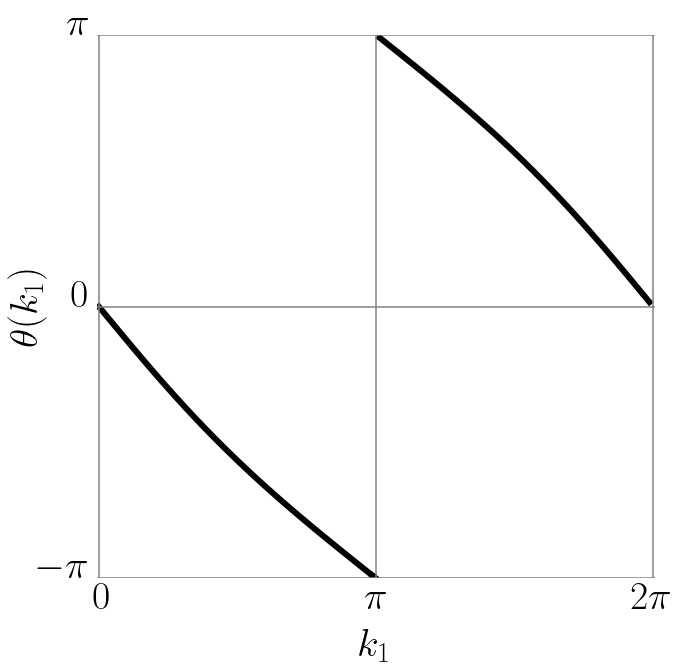

In [87]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)


plt.figure(figsize=(10,10))
frame1 = plt.gca()
plt.tick_params(axis = 'x', which = "both", bottom = None, top = None,labelbottom=False)
plt.tick_params(axis = 'y', which = "both", bottom = None, top = None,labelleft=False)

values0=np.mod(np.real(arrayOfwMp1)-2*np.pi*np.array(range(150))/150.0 +np.pi,2*np.pi) # add the Abelian contribution.
# because we want to plot from -\pi to \pi, but np.mod will force values between 0 and 2*np.pi, we add np.pi and change
# the labels accordingly.

plt.plot(range(150)[0:75], values0[0:75],c='black',linewidth=6) 
plt.plot(range(150)[74:77], [values0[74],values0[75],values0[76]-2*np.pi],c='black',linewidth=6) 
plt.plot(range(150)[76:150], values0[76:150],c='black',linewidth=6) 


plt.axhline(y=0,color='gray')
plt.axhline(y=np.pi,color='gray')
plt.axhline(y=2*np.pi,color='gray')

plt.text(-16.75,0,r'$-\pi$',rotation=0)
plt.text(-7.5,np.pi,r'$0$',rotation=0)
plt.text(-8.5,2*np.pi,r'$\pi$',rotation=0)

plt.axvline(x=0,color='gray')
plt.axvline(x=75,color='gray')
plt.axvline(x=150,color='gray')

plt.text(0-1.5,-0.35,r'$0$',rotation=0)
plt.text(75-3,-0.35,r'$\pi$',rotation=0)
plt.text(150-6,-0.35,r'$2\pi$',rotation=0)
plt.xlim([-0.5,150.5])
plt.ylim([0,2*np.pi])

plt.ylabel(r'$\theta(k_1)$',labelpad=50)
plt.xlabel(r'$k_1$',labelpad=50)
ax = plt.subplot(111)
ax.set_frame_on(False)
plt.tick_params(left=False)

plt.savefig('low_W_Wilson_neg.png') # and plot

As one final check, we implement the check discussed in Eq.(A195), where $U = I$ and the Wilson loop gives ${\cal H}^{-2\pi b_2}$

In [89]:
def checkWilsonSpectrum(path):
    for j1, k_vec in enumerate(path):

        u_matrix_p1 = np.identity(20)
        
        if j1 == 0:
            w_last_p1 = u_matrix_p1
            w_first_p1 = u_matrix_p1.conj().T         
            
        else:
            w_last_p1 = np.dot(u_matrix_p1, np.dot(u_matrix_p1.conj().T, np.dot(expm_mat ,w_last_p1)))
        
    return(np.dot(w_first_p1,np.dot(expm_mat,w_last_p1)))


wMp1 = checkWilsonSpectrum(path_k1[0]) # get the Wilson Hamiltonian, which in this case is just a number

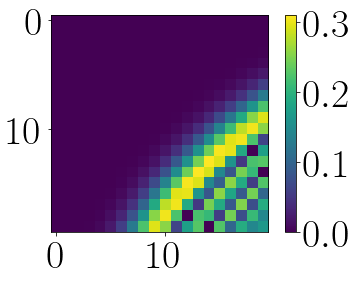

In [108]:
plt.imshow(abs(wMp1-formFactors2.conj().T[:20,:20]))
plt.colorbar()

The difference is supposed to be $0$ everywhere for equality, but notice it gets worse at higher landau level because of the cutoff.  Now for the strong limit

In [119]:
w = 7.0
phi = 2*np.pi

In [120]:
num_landau = 20 # number of Landau levels to keep
kinetic = np.zeros((num_landau,num_landau)) # matrix to hold the kinetic energies corresponding to each LL

# First create the kinetic terms
for m in range(num_landau): 
    kinetic[m][m] = phi*(m+1./2)

def generateHam(k): # given a momentum k,
    k1 = np.dot(a1,k)
    k2 = np.dot(a2,k)
    hamiltonian = kinetic + w/2*formFactors1[:num_landau,:num_landau]*np.exp( 1.0j *(-k2)) \
    + w/2*formFactors2[:num_landau,:num_landau]*np.exp(1.0j *(k1)) \
    + w/2*(formFactors1.conj().T)[:num_landau,:num_landau]*np.exp(1.0j *(k2)) \
    + w/2*(formFactors2.conj().T)[:num_landau,:num_landau]*np.exp(1.0j *(-k1))     
    return(hamiltonian)

In [121]:
listOfEigenvals = []  # will hold all the eigenvalues.
for i, k_vec in enumerate(list_of_points):  # for each k-point in the path
    ham = generateHam(k_vec)  # build Hk
    eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
    listOfEigenvals.append(eigenvals)  # add to list

In [122]:
listOfValsForHistogram = []

for i in range(50): # 2500 points to create histogram
    for j in range(50):
        ham = generateHam(2*np.pi*i/50.0*b1+2*np.pi*j/50.0*b2)
        eigval, eigvec = np.linalg.eigh(ham)
        listOfValsForHistogram.append(eigval[:5]) # for the first 5 bands

In [123]:
hist = np.array(listOfValsForHistogram).flatten()
a, b = np.histogram(hist, bins=200)
q = b[:200] + np.diff(b)/2.0
b[0]-np.diff(b)[0]/2.0
b[-1]+np.diff(b)[0]/2.0
np.diff(b)[3]*sum(a)

2111.9708269779117

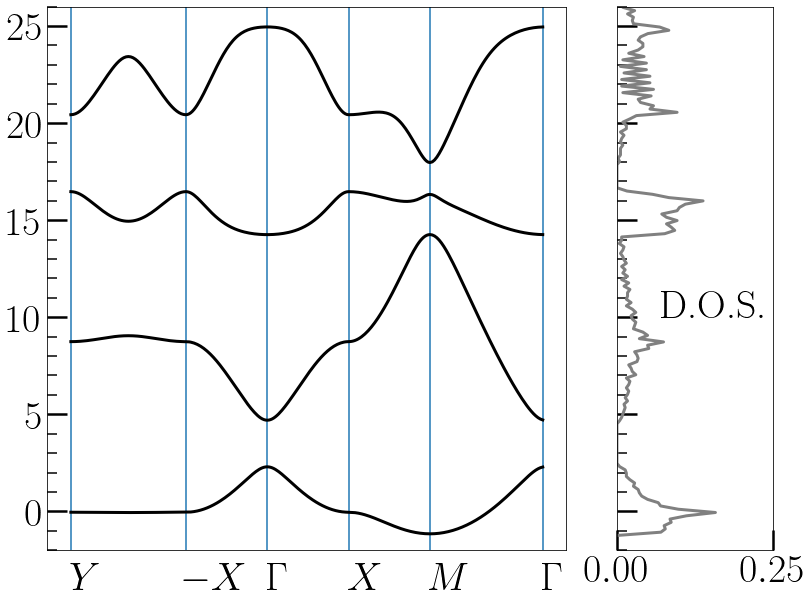

In [124]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 10), gridspec_kw={'width_ratios': [1,0.3]})
plt.subplots_adjust(wspace=0.15)

axes[0].get_xaxis().set_visible(False)
axes[0].tick_params(direction="in",width=2.5, length=20)

axes[0].axes.get_xaxis().set_visible(False)

arrayOfEigenvals=np.array(listOfEigenvals)# take the 8 bands closest to 0 energy
axes[0].axvline(x=len_k[0])
axes[0].text(len_k[0]-.05,-4,r'$Y$',rotation=0)
axes[0].axvline(x=len_k[50])
axes[0].text(len_k[50]-.1,-4,r'$-X$',rotation=0)
axes[0].axvline(x=len_k[100])
axes[0].text(len_k[100]-.025,-4,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[150])
axes[0].text(len_k[150]-.05,-4,r'$X$',rotation=0)
axes[0].axvline(x=len_k[200])
axes[0].text(len_k[200]-.075,-4,r'$M$',rotation=0)
axes[0].axvline(x=len_k[249])
axes[0].text(len_k[249]-.025,-4,r"$\Gamma$",rotation=0)
axes[0].set_ylim([-2, 26])

for i in range(0,4):
    axes[0].plot(len_k, arrayOfEigenvals[:,i],linewidth=3,color='black')

axes[0].get_yaxis().set_major_locator(MultipleLocator(5))
axes[0].get_yaxis().set_minor_locator(MultipleLocator(1))
axes[0].tick_params(which='major',direction="in",width=2.5, length=20)
axes[0].tick_params(which='minor',direction="in",width=1.5, length=10)
    
axes[1].get_yaxis().set_ticklabels([])
axes[1].get_yaxis().set_major_locator(MultipleLocator(50))
axes[1].get_yaxis().set_minor_locator(MultipleLocator(10))

ap = np.concatenate(([0],a,[0]))
qp = np.concatenate(([b[0]-np.diff(b)[0]/2.0],q,[b[-1]+np.diff(b)[0]/2.0]))

axes[1].plot(ap/2112, qp, linewidth=3, color='gray')
axes[1].get_yaxis().set_major_locator(MultipleLocator(5))
axes[1].get_yaxis().set_minor_locator(MultipleLocator(1))
axes[1].tick_params(which='major',direction="in",width=2.5, length=20)
axes[1].tick_params(which='minor',direction="in",width=1.5, length=10)

axes[1].set_xlim([0, 0.25])
axes[1].set_ylim([-2, 26])

axes[0].tick_params(direction="in",width=2.5, length=20)
axes[1].text(0.07,10,r"D.O.S.",rotation=0)

plt.savefig('SquareFluxHighW.png',bbox_inches='tight')

In [125]:
expm_mat = sp.linalg.expm(1.0j*2*np.pi/150.0*z1_total_mat)

def getWilsonSpectrum(path):
    for j1, k_vec in enumerate(path):

        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
        u_matrix_p1 = eigenvecs[:,0] # first band wavefunction
        
        if j1 == 0:
            w_last_p1 = u_matrix_p1
            w_first_p1 = u_matrix_p1.conj().T         
            
        else:
            w_last_p1 = np.dot(u_matrix_p1, np.dot(u_matrix_p1.conj().T, np.dot(expm_mat ,w_last_p1)))
        
    return(np.dot(w_first_p1,np.dot(expm_mat,w_last_p1)))

In [126]:
listOfwMp1 = []

for path in path_k1: # for each loop
    wMp1 = getWilsonSpectrum(path) # get the Wilson Hamiltonian, which in this case is just a number
    #listOfwMp1.append(wMp1)
    listOfwMp1.append(-1.0j*np.log(wMp1)) # -i * log gives the Wannier eigenvalue \theta
    
arrayOfwMp1 = np.array(listOfwMp1) # gather into a numpy array

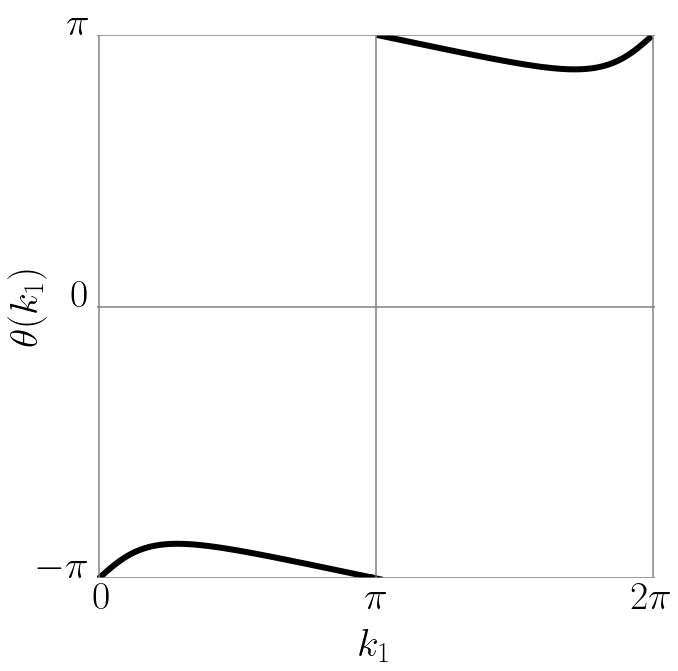

In [131]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)


plt.figure(figsize=(10,10))
frame1 = plt.gca()
plt.tick_params(axis = 'x', which = "both", bottom = None, top = None,labelbottom=False)
plt.tick_params(axis = 'y', which = "both", bottom = None, top = None,labelleft=False)

values0=np.mod(np.real(arrayOfwMp1)-2*np.pi*np.array(range(150))/150.0 +np.pi,2*np.pi)

plt.plot(range(150)[:75], values0[:75],c='black',linewidth=6)  
plt.plot(range(150)[74:77], [values0[74],values0[75],values0[76]-2*np.pi],c='black',linewidth=6)  
plt.plot(range(150)[76:150], values0[76:150],c='black',linewidth=6)  

#Why do we add 2\pi to some of the values?  Because the Wilson loop eigenvalues are defined mod 2\pi, this is
# totally acceptable, and only serves the prevent lines from jumping from -\pi to \pi in the plot.

plt.axhline(y=0,color='gray')
plt.axhline(y=np.pi,color='gray')
plt.axhline(y=2*np.pi,color='gray')

plt.text(-16.75,0,r'$-\pi$',rotation=0)
plt.text(-7.5,np.pi,r'$0$',rotation=0)
plt.text(-8.5,2*np.pi,r'$\pi$',rotation=0)

plt.axvline(x=0,color='gray')
plt.axvline(x=75,color='gray')
plt.axvline(x=150,color='gray')

plt.text(0-1.5,-0.35,r'$0$',rotation=0)
plt.text(75-3,-0.35,r'$\pi$',rotation=0)
plt.text(150-6,-0.35,r'$2\pi$',rotation=0)
plt.xlim([-0.5,150.5])
plt.ylim([0,2*np.pi])

plt.ylabel(r'$\theta(k_1)$',labelpad=50)
plt.xlabel(r'$k_1$',labelpad=50)
ax = plt.subplot(111)
ax.set_frame_on(False)
plt.tick_params(left=False)

plt.savefig('high_W_Wilson_neg.png')